<a href="https://colab.research.google.com/github/ZacharySBrown/vcu-scma440-2021q1/blob/master/examples/8a_arima_errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Fetch Data
Press the play button in Google Colab or press Shift+Enter execute the cell below to download and load the data and packages for this assignment

This will setup you environment and load a DataFrame called `petrol` with data from chapter 8 of Makridakis.

In [1]:
! pip install --upgrade statsmodels

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


from scipy.stats import t, f

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16

!curl https://vcu-scma-440.s3.amazonaws.com/data/petrol.csv > petrol.csv



petrol = pd.read_csv('petrol.csv', parse_dates=['date']).set_index('date')

Requirement already up-to-date: statsmodels in /opt/miniconda3/lib/python3.7/site-packages (0.12.2)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9435  100  9435    0     0  78625      0 --:--:-- --:--:-- --:--:--     0:--:-- 79285


# Exploring the Data

First, let's take a look at our time series

,chemicals,coal,petrol,vehicles
date,,,,
1971-01-01,3.896,49.780,2.154,4.367
1971-02-01,4.346,47.029,2.250,5.147
1971-03-01,4.318,56.920,2.165,5.418
1971-04-01,4.536,54.336,2.223,4.897
1971-05-01,4.454,50.442,2.190,5.002


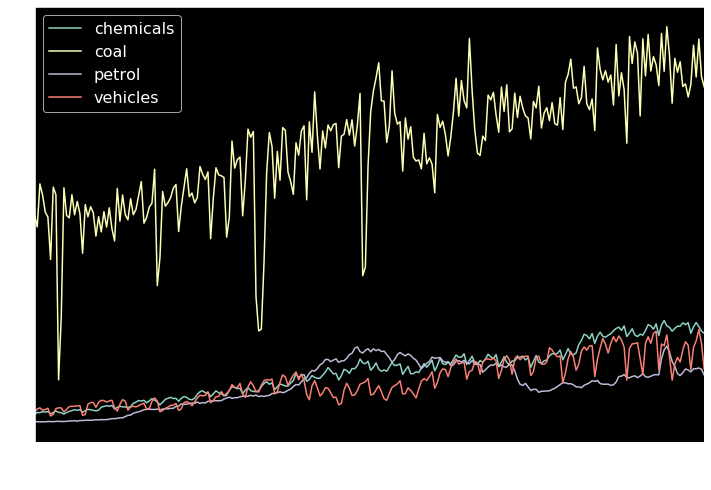

In [5]:
display(petrol.head())
petrol.plot()

This data is clearly non-stationary in the variance, so we'll begin by taking the log transform of each of the series:

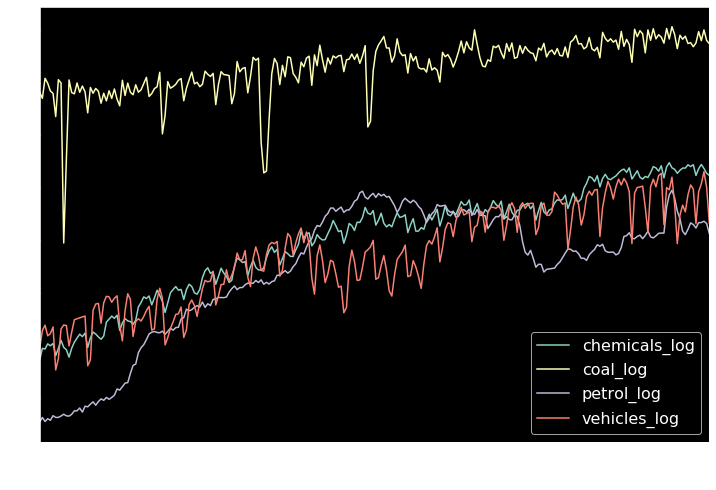

In [9]:
petrol['chemicals_log'] = np.log(petrol['chemicals'])
petrol['coal_log'] = np.log(petrol['coal'])
petrol['petrol_log'] = np.log(petrol['petrol'])
petrol['vehicles_log'] = np.log(petrol['vehicles'])
petrol[['chemicals_log','coal_log','petrol_log','vehicles_log']].plot()

Next, we'll want to difference our time series:

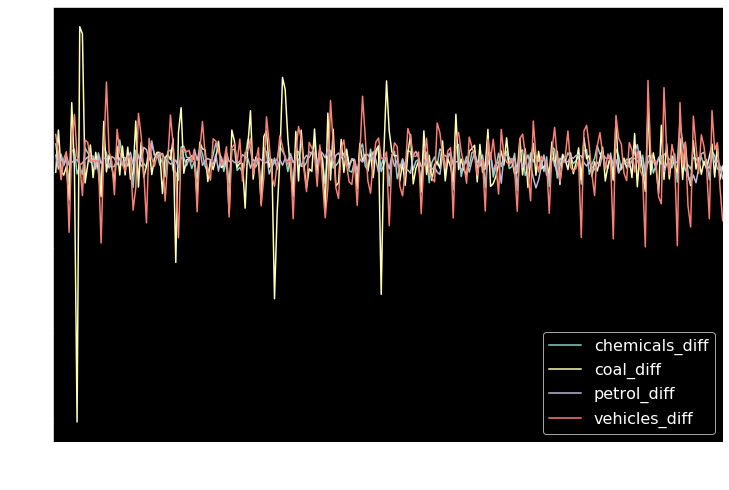

In [18]:
petrol['chemicals_diff'] = petrol['chemicals_log'].diff()
petrol['coal_diff'] = petrol['coal_log'].diff()
petrol['petrol_diff'] = petrol['petrol_log'].diff()
petrol['vehicles_diff'] = petrol['vehicles_log'].diff()
petrol[['chemicals_diff','coal_diff','petrol_diff','vehicles_diff']].plot()

petrol=petrol.dropna()

Now, we can use the `ARIMA` function to specify a regression with ARIMA errors by specifying both the `exog` and `endog` parameters, as well as the order of our ARIMA and seasonal ARIMA models. We also specify here `trend='n'` to prevent the model from fitting a constant linear trend to our (now stationary) data. 

In [29]:
model = ARIMA(
    endog=petrol['petrol_diff'], 
    exog=petrol[['chemicals_diff','coal_diff','vehicles_diff']], 
    order=(1,0,0), 
    seasonal_order=(1,0,0,12),
    trend='n'
)

results = model.fit()

print(results.summary())

/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                    SARIMAX Results                                     
Dep. Variable:                      petrol_diff   No. Observations:                  251
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 465.275
Date:                          Sat, 17 Apr 2021   AIC                           -918.550
Time:                                  14:34:31   BIC                           -897.398
Sample:                              02-01-1971   HQIC                          -910.038
                                   - 12-01-1991                                         
Covariance Type:                            opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
chemicals_diff     0.2576      0.055      4.647      0.000       0.149       0.366
coal_diff         -0.0263      0.022   

From the above, we can see that two of the regression coefficients are _not_ significant. We can remove these, then perform the fit again:

In [52]:
model = ARIMA(
    endog=petrol['petrol_diff'], 
    exog=petrol[['chemicals_diff']], 
    order=(1,0,0), 
    seasonal_order=(1,0,0,12),
    trend='n'
)

results = model.fit()

print(results.summary())

/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                    SARIMAX Results                                     
Dep. Variable:                      petrol_diff   No. Observations:                  251
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 462.649
Date:                          Sat, 17 Apr 2021   AIC                           -917.297
Time:                                  14:42:57   BIC                           -903.195
Sample:                              02-01-1971   HQIC                          -911.622
                                   - 12-01-1991                                         
Covariance Type:                            opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
chemicals_diff     0.2132      0.048      4.485      0.000       0.120       0.306
ar.L1              0.3509      0.056   

The last thing that we want to do is examine our overall residuals for stationarity and autocorrelations. We already have some indication of lack of autocorrelation in the residuals from the very small Ljung-Box Q value (and corresponding large p-value), but we can take a quick look at the ACF and PACF of the residuals to double-check

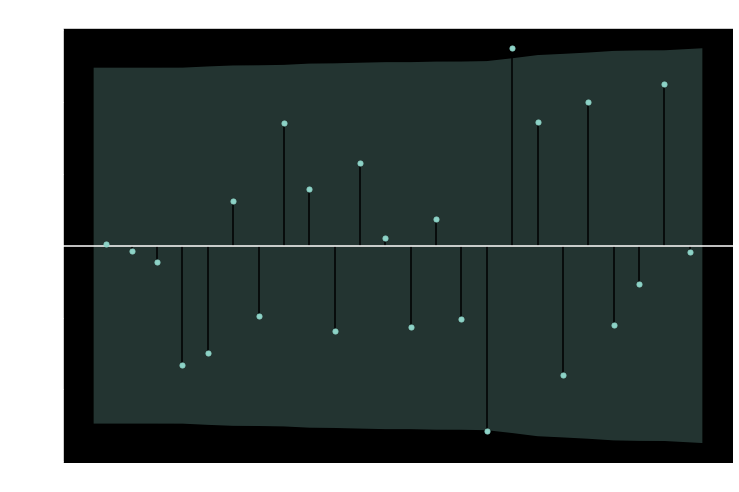

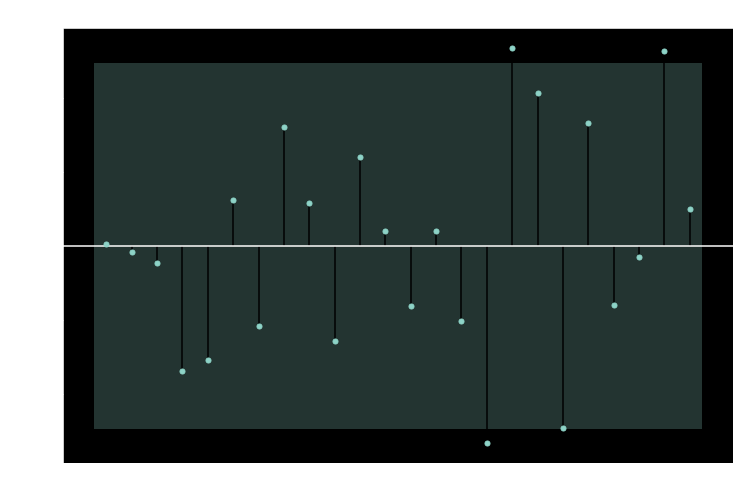

In [53]:
my_acf = plot_acf(results.resid, zero=False)
my_pacf = plot_pacf(results.resid, zero=False)

The above plots confirm that there is very little autocorrelation remaining